# Example of how to use the Orca wrapper


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
import logging

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import MolsToGridImage, MolToImage
from rdkit.Chem.MolStandardize import rdMolStandardize

In [4]:
try:
    import ppqm
except ModuleNotFoundError:
    import pathlib

    cwd = pathlib.Path().resolve().parent
    sys.path.append(str(cwd))
    import ppqm

In [5]:
from ppqm import orca
from ppqm import jupyter as ppqm_jupyter

## Set logging level

In [6]:
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logging.getLogger("ppqm").setLevel(logging.INFO)
logging.getLogger("orca").setLevel(logging.DEBUG)
show_progress = True

In [7]:
_logger = logging.getLogger(__name__)

## Define a molecule you like

In [8]:
smiles = "C([C@@H](C(=O)O)N)O"  # I like serine
molobj = Chem.MolFromSmiles(smiles)

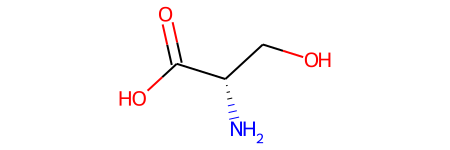

In [9]:
molobj

## Define an Orca calculator object

In [10]:
orca_options = {
    "scr": "./_tmp_directory_",  # Where should the calculations happen?
    "cmd": "orca",  # Where is the binary executable/command?
    "n_cores": 8,  # How many cores to use?
    "show_progress": True,  # Show progressbar during calculation
}

In [11]:
calc = orca.OrcaCalculator(**orca_options)
calc

OrcaCalc(cmd=/home/cloudlab/Library/orca/5.0.3-serial/orca, scr=_tmp_directory_, n_cores=8, memory=2gb)

## Define what you would like to calculate

In [12]:
# Calculate values for molecule in water
calculation_option = {
    "NumFreq": None,
    "B3LYP": None,
    "def2-SVP": None,
    "D3BJ": None,
    "Hirshfeld": None,
    "CPCM": "water",
    "RIJCOSX": None,
    "def2/J": None,
    "Grid4": None,
    "GridX4": None,
    "NMR": None,
    "def2/JK": None
}

In [13]:
# Generate conformers
molobj_conf = ppqm.tasks.generate_conformers(molobj, max_conformers=3)

In [14]:
molobj_conf.GetNumConformers()

3

In [15]:
# Calculate energy of conformers
results = calc.calculate(molobj_conf, calculation_option)

DEBUG:orca:start orca multiprocessing pool
INFO:orca:Using 2 core(s) per conformer
INFO:orca:3 conformer(s) in total on 6 cores
ORCA(3):   0%|                                            | 0/3 [00:00<?, ?it/s]DEBUG:orca:/home/cloudlab/Library/orca/5.0.3-serial/orca _tmp_orca_input.inp
DEBUG:orca:/home/cloudlab/Library/orca/5.0.3-serial/orca _tmp_orca_input.inp
DEBUG:orca:/home/cloudlab/Library/orca/5.0.3-serial/orca _tmp_orca_input.inp
ERROR:orca:Abnormal termination of Orca
ERROR:orca:orca: INPUT ERROR
ERROR:orca:orca: UNRECOGNIZED OR DUPLICATED KEYWORD(S) IN SIMPLE INPUT LINE
ERROR:orca:orca: GRID4 GRIDX4
ERROR:orca:Abnormal termination of Orca
ORCA(3):  33%|████████████                        | 1/3 [00:00<00:00,  7.99it/s]ERROR:orca:orca: INPUT ERROR
ERROR:orca:orca: UNRECOGNIZED OR DUPLICATED KEYWORD(S) IN SIMPLE INPUT LINE
ERROR:orca:orca: GRID4 GRIDX4
ERROR:orca:Abnormal termination of Orca
ERROR:orca:orca: INPUT ERROR
ERROR:orca:orca: UNRECOGNIZED OR DUPLICATED KEYWORD(S) IN SIMP

In [ ]:
# The output type
print(type(results))
print(type(results[0]))
print(results[0].keys())

In [ ]:
# Collect all the orca energies
conformer_energies = [result["scf_energy"] for result in results]

In [ ]:
# Find the lowest energy
idx = np.argmin(conformer_energies)
idx

## Transfer the results into a Pandas dataframe

In [ ]:
df = pd.DataFrame(results)
df

In [ ]:
# get coordinates for lowest energy conformer
coord = results[idx]["coord"]

In [ ]:
# get mulliken charges for lowest energy conformer
mulliken = results[idx]["mulliken_charges"]
mulliken

In [ ]:
# Copy only the graph of the molecule, keeping the atom order
molobj_prime = ppqm.chembridge.copy_molobj(molobj_conf)

# Get the coordinates of the best conformer
coord = results[idx]["coord"]

# Add conformer to molobj
ppqm.chembridge.molobj_add_conformer(molobj_prime, coord)

In [ ]:
ppqm_jupyter.show_molobj(molobj_prime)

In [ ]:
for coef, atom in zip(mulliken, molobj_prime.GetAtoms()):
    label = f"{coef:.2f}"
    atom.SetProp("atomNote", label)

In [ ]:
MolToImage(
    Chem.RemoveHs(molobj_prime),
    size=(300, 300),
)